# APLICACIÓN KMEANS 

**Contenido**

1. DISEÑO DEL ALGORITMO
2. OBSERVACIONES
3. REQUERIMIENTOS


El objetivo de este notebook es la implementación del algoritmo Kmeans con el fin de extraer patrones de comportamiento específicos y con detalles técnicos 


<div class="alert alert-info" style="margin: 20px">
Se decide crear este algoritmo con el fin de obtener mayor grado de detales en las OT de las base de datos. En otras palabras, se busca identificar clusters específicos, conservando el sentido semantico de la oración, a diferencia del anterior estructura LDA que permitió tener una visión general. </div>

# I. DISEÑO DEL ALGORITMO

#### Importar paquetes

In [1]:
import collections
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pprint import pprint
import numpy as np
from string import punctuation
from time import time
import os
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt

# Stop Words
with open('../spanish4.0.txt','r') as f:
    stop_words = f.read().splitlines()

#### Estructura del algoritmo

##### Selección de K óptimo

In [2]:
# Tokenizar palabras
def word_tokenizer(text):    
    tokens = word_tokenize(text)   # tokenizes and stems the text
    # non_words = list(punctuation)  # removes punctuation 
    # text = ''.join([c for c in text if c not in non_words]) ---> Data ingresada ya está libre de puntuación
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words] # Posibilidad de extender stopwords
    return tokens

# Elbow Method
def elbow_method(sentences,figsize = (8,5),  namecol=None, nro_top=None, save = False,width_text=0.82, height_text=0.90):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)   #builds a tf-idf matrix for the sentences
    import warnings
    
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if len(sentences)<= 30:
                list_k = list(range(1,len(sentences)+1))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)

            elif len(sentences)> 30 and len(sentences)<= 70:
                list_k = list(range(2,len(sentences)+1,2))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)     

            else:     
                list_k = list(range(2,51,2))
                elbow = []
                for i in list_k:
                    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    kmeans.fit(tfidf_matrix)
                    elbow.append(kmeans.inertia_)

            from kneed import KneeLocator
            kn = KneeLocator(list_k, elbow, curve='convex', direction='decreasing')
            print(f'Número óptimo de clusters: {kn.knee}')

            plt.rcParams.update({'figure.figsize':figsize})
            plt.xlabel('Número de clusters k')
            plt.ylabel('Suma de distancias cuadradas')
            plt.plot(list_k, elbow, 'bo-')
            plt.title('Método del Elbow')
            plt.text(width_text, height_text, f'k óptimo: {kn.knee}', transform=plt.gca().transAxes)
            plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
            if save :
                plt.savefig(f'{namecol} {nro_top} - Método del elbow.jpg', dpi= 200, quality=95)
            plt.show()

    except ValueError:
        print('You must enter at least two sentences')

In [3]:
# Análisis de Silueta General
def silhouette(sentences,figsize = (8,5),  namecol=None, nro_top=None, save = False, width_text=0.82, height_text=0.10):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    X_std = tfidf_vectorizer.fit_transform(sentences)
    import warnings
    
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if len(sentences)<= 30:
                list_k = list(range(1,len(sentences)+1))
                silhouette_scores= []
                for i in list_k:
                    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    labels = km.fit_predict(X_std)
                    centroids = km.cluster_centers_
                    silhouette_vals = silhouette_samples(X_std, labels)
                    silhouette_scores.append(np.mean(silhouette_vals))

            elif len(sentences)> 30 and len(sentences)<= 70:
                list_k = list(range(2,len(sentences)+1,2))
                silhouette_scores= []
                for i in list_k:
                    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    labels = km.fit_predict(X_std)
                    centroids = km.cluster_centers_
                    silhouette_vals = silhouette_samples(X_std, labels)
                    silhouette_scores.append(np.mean(silhouette_vals))     

            else:     
                list_k = list(range(2,51,2))
                silhouette_scores= []
                for i in list_k:
                    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 101)
                    labels = km.fit_predict(X_std)
                    centroids = km.cluster_centers_
                    silhouette_vals = silhouette_samples(X_std, labels)
                    silhouette_scores.append(np.mean(silhouette_vals))
                    
            from kneed import KneeLocator
            kn = KneeLocator(list_k, silhouette_scores, curve='concave', direction='increasing')
            print(f'Número óptimo de clusters: {kn.knee}')

            plt.rcParams.update({'figure.figsize':figsize})
            plt.xlabel('Número de clusters k')
            plt.ylabel('Coeficientes de silueta')
            plt.plot(list_k, silhouette_scores, 'ro-')
            plt.title('Análisis de silueta')
            plt.text(width_text, height_text, f'k óptimo: {kn.knee}', transform=plt.gca().transAxes)
            plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
            if save :
                plt.savefig(f'{namecol} {nro_top} - Análisis de silueta general.jpg', dpi= 200, quality=95)
            plt.show()

    except ValueError:
        print('You must enter at least two sentences')

In [4]:
# Análisis de Silueta Particular (Gráfico de barras por tópico)
def silhouette_plot(sentences, n_clusters, figsize=(8,5), width=1.02, height=0.96):
    fig, ax1 = plt.subplots()
    plt.rcParams.update({'figure.figsize':figsize})
    plt.rcParams.update({'figure.autolayout': False})
    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    X_std = tfidf_vectorizer.fit_transform(sentences)

    # Run the Kmeans algorithm
    km = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 101)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Coeficientes de Silueta')
    ax1.set_ylabel('Clusters')
    ax1.set_title(f'Análisis de Silueta para k = {n_clusters}', y=1.02)
    plt.text(width, height, f'Silhouette Score: {round(avg_score,4)}', transform=plt.gca().transAxes);
    
def silhouette_analysis(sentences, n_clusters, save = False, name= None):
    for k in n_clusters:
        silhouette_plot(sentences,n_clusters=k)
        if save:
            plt.savefig(f'Silueta - {name} con k {k}.jpg', dpi= 200, quality=95)

##### Algoritmo K-Means

In [5]:
# Algoritmo Kmeans
def cluster_sentences(sentences, nb_of_clusters):

    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,stop_words=stop_words,lowercase=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)   #builds a tf-idf matrix for the sentences
    
    kmeans = KMeans(n_clusters = nb_of_clusters, init = 'k-means++', random_state = 101, max_iter=300)
    #kmeans.fit(tfidf_matrix)
    X_dist=kmeans.fit_transform(tfidf_matrix)**2  #Se calcula la distancia del cluster y se multiplica al cuadrado
    clusters = collections.defaultdict(list)
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(i)

    Distancia=X_dist.sum(axis=1)  #Se calcula la distancia por columna de la matriz

    distDict={}  #Se traspasa a un diccionario con las distancias por cluster
    for key,val in clusters.items():
        distDict[key]=Distancia[val]

    representativos=[]   # Se guarda en una lista los valores mínimos de cada cluster (Menor distancia al centro mejor es el representativo)
    
    #Verificacion de los numeros de clusters
    #Si se intenta obtener los representativos de un número mas grande de cluster que el permitido, se procesa el número de clusters
    if len(distDict)<nb_of_clusters:
        nb_of_clusters=len(distDict)
        
    #Verificacion de los números de clústers
    for i in range(nb_of_clusters):
        representativos.append(np.where(distDict[i]==min(distDict[i]))[0][0])

    return dict(clusters),representativos

# Plot cantidad de sentences por cluster
def len_clusters(dic, n, namecol=None, nro_top=None, save = False, width = 0.6, color = "royalblue", figsize = (8,5)):
    keys = list(range(0,n))
    len_values = [len(dic[i]) for i in keys]
    plt.rcParams.update({'figure.figsize': figsize})
    plt.bar(keys,len_values , align='center', color = color, width = width)
    plt.title('Cantidad de OT por cluster')
    plt.xlabel('Clusters')
    plt.ylabel('Orden de Trabajo (OT)')
    plt.xticks(np.arange(min(keys), max(keys)+1, 1.0))
    if save:
        plt.savefig(f'{namecol} {nro_top} - Distribucion clusters .jpg', dpi= 200, quality=95)
    plt.show()

<div class="alert alert-success" style="margin: 20px">En todos los data frames ya está implementada la función word_cleaner() que permitió limpiar la base de datos. Para más información de esta función ir al segundo notebook.</div>


#### Importar Data Frame

In [6]:
df_total = pd.read_pickle('../2. Topic Modeling - LDA 24 topics/BD_original_cleaned_TOPICO_DOMINANTE.pkl')
df_total.head()

,Region,Estacion,Tipo de Falla,Prioridad Cliente,Estado OT,Tecnico Asignado,Dia,Nro Dia,Mes,Hora,Rango Recep/Arribo,Rango Arribo/Cierre,Observación,Requerimiento,Topico Dominante
0,13°,Tingaro Spa.,Carrete RetractilOTROOTRO,Normal 48 Horas,CERRADA,Juan Aliaga,Viernes,30,AGO 19,16,Error en fechas,Más de 1 mes,se cambia placa de tk 2 gas95 por placa que in...,area de atencion habilitar estanque de combust...,2
1,8°,Combustibles El Volcan Ltda.,Carrete RetractilOTROOTRO,Normal (48 hrs),CERRADA,On Line,Viernes,30,AGO 19,12,Error en fechas,Menos de 1h,cambio de graficas de equipos no esta contempl...,area de atencion combustible maria veronica go...,23
2,10°,LLANOS Y WAMMES SOCIEDAD COMERCIAL LTDA.,Carrete RetractilOTROOTRO,Normal 24 Horas,PRECIERRE,Luis Almonacid,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,se visita eds para chequeo de dispensador el c...,area de atencion surtidor de diesel a ratos co...,3
3,1°,Soc. Imp. y Exp. Nuevo Amanecer Ltda. (SOCIEX),Carrete RetractilOTROOTRO,Normal (48 hrs),CERRADA,On Line,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,remplazo de graficas no esta contemplado en es...,area de atencion combustible cambiar graficas ...,4
4,3°,Inmobiliaria e Inversiones San José Ltda (Vall...,Carrete RetractilOTROOTRO,Normal (48 hrs),CERRADA,On Line,Viernes,30,AGO 19,12,Error en fechas,Menos de 1h,remplazo de graficas no esta contemplado en co...,area de atencion combustible solicita grafica ...,4


# II. OBSERVACIONES

In [7]:
# SELECCIONANDO UNA COLUMNA Y UN ELEMENTO DE ESA COLUMNA (Escribir con comillas. Ej: 'Tecnico Asignado')

columna = 'Estacion'
elemento = 'CL - Buses Vule S.A.'

In [8]:
df = df_total[df_total[columna] == elemento] 
sentences = [sent for sent in df['Observación']]
len(sentences)

151

In [9]:
# Extracto obs 
sentences[:2]

['en surtidor numero 1 se detecto se cambio 01 breakaways de 1 cortado se realizan pruebas con ventas quedando operativa en surtidor numero 1 se detecto se cambio 01 breakaways de 1 cortado se realizan pruebas con ventas quedando operativa',
 'en surtidor numero 2 se revisa consumo electrico de motor y se detecto fases sueltas desde guardamotor en tablero electrico hacia motor del surtidor se realizan pruebas con ventas y midiendo consumo electrico del motor no detectando anomalias una vez reapretado y reajustado rango y sistema electrico en surtidor numero 2 se revisa consumo electrico de motor y se detecto fases sueltas desde guardamotor en tablero electrico hacia motor del surtidor se realizan pruebas con ventas y midiendo consumo electrico del motor no detectando anomalias una vez reapretado y reajustado rango y sistema electrico']

Número óptimo de clusters: 16


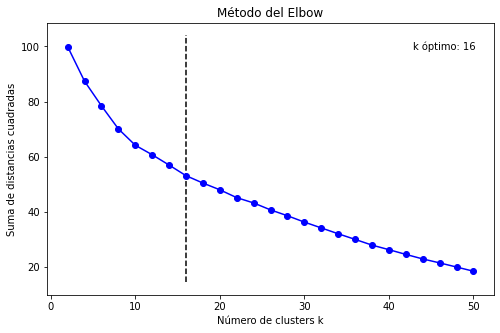

Wall time: 6 s


In [10]:
%%time
# Identificando el número óptimo de clústers por medio del Método del Elbow
elbow_method(sentences, save = False)

Número óptimo de clusters: 16


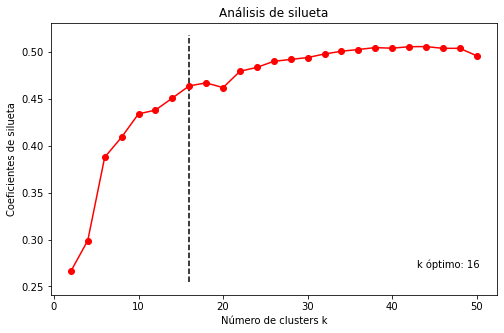

Wall time: 5.92 s


In [11]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta General
silhouette(sentences, save = False)

Wall time: 2.43 s


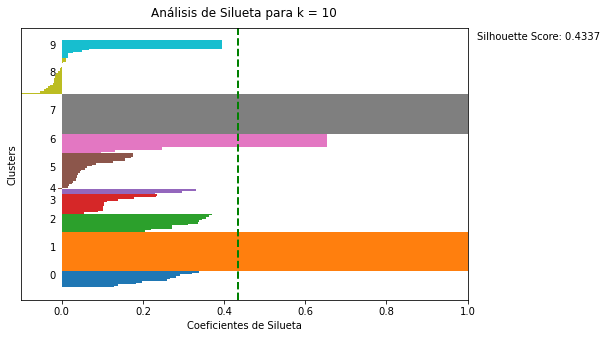

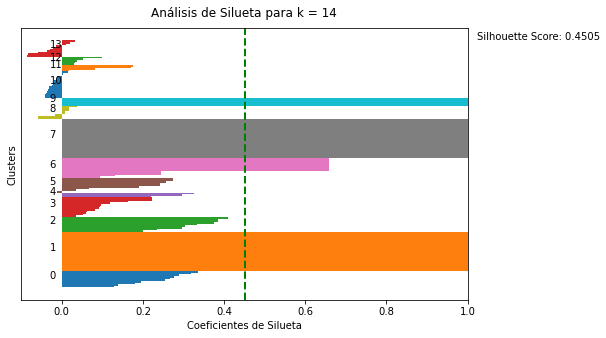

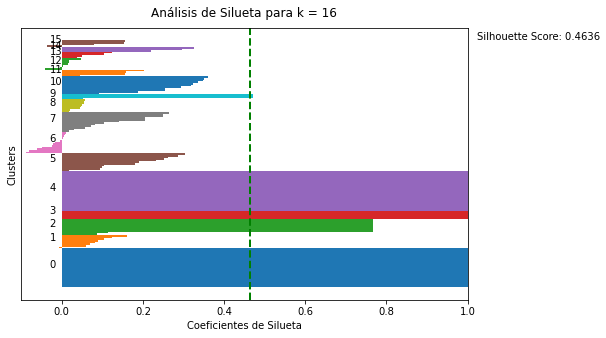

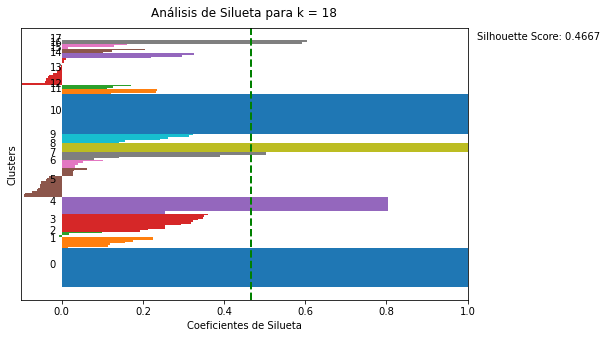

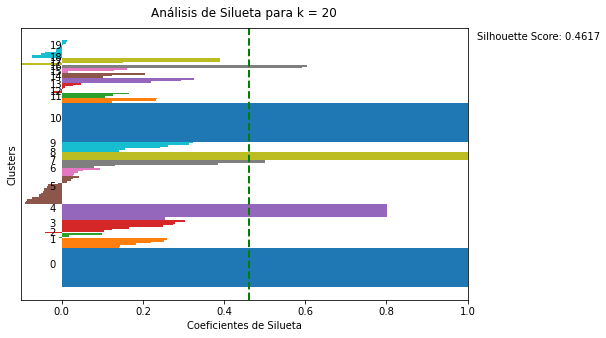

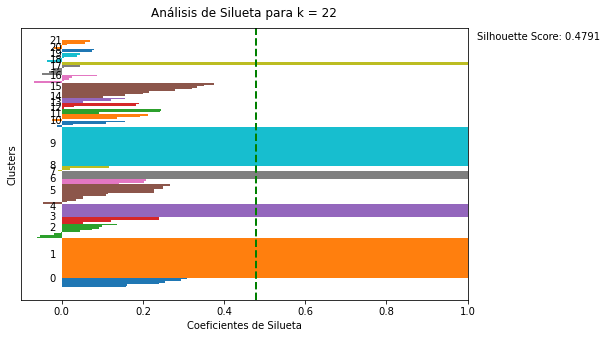

In [12]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta Particular (por tópico)
silhouette_analysis(sentences, n_clusters=[10,14,16,18,20,22], name= elemento, save=False )

In [13]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters=16
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : ods mal emitida
	sentence  0 :  ods mal emitida
	sentence  1 :  ods mal emitida
	sentence  2 :  ods mal emitida
	sentence  3 :  ods mal emitida
	sentence  4 :  ods mal emitida
	sentence  5 :  ods mal emitida
	sentence  6 :  ods mal emitida
	sentence  7 :  ods mal emitida
	sentence  8 :  ods mal emitida
	sentence  9 :  ods mal emitida
	sentence  10 :  ods mal emitida
	sentence  11 :  ods mal emitida
	sentence  12 :  ods mal emitida
	sentence  13 :  ods mal emitida
	sentence  14 :  ods mal emitida
	sentence  15 :  ods mal emitida
	sentence  16 :  ods mal emitida
	sentence  17 :  ods mal emitida
	sentence  18 :  ods mal emitida
	sentence  19 :  ods mal emitida
	sentence  20 :  ods mal emitida
	sentence  21 :  ods mal emitida
	sentence  22 :  ods mal emitida
	sentence  23 :  ods mal emitida
Cluster 1 : surt 1 d se realizo remplazo de un filtro de alta cap surt 1 d se realizo remplazo de un filtro de alta cap
	sentence  0 :  se coordinara una proxima visita para am su

In [14]:
# Clusters representativos (con n = 16)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : ods mal emitida
Cluster  1 : surt 1 d se realizo remplazo de un filtro de alta cap surt 1 d se realizo remplazo de un filtro de alta cap
Cluster  2 : mantencion preventiva se calibran 2 de 2
Cluster  3 : se realiza el cambio de 2 filtros spin on quedando equipo operativo
Cluster  4 : os mal emitida
Cluster  5 : mantencion preventiva se realizara bajo ot 5
Cluster  6 : en surtidores 1 y 2 diesel se cambia 02 filtros p14187 quedando 100 operativos en surtidores 1 y 2 diesel se cambia 02 filtros p14187 quedando 100 operativos
Cluster  7 : se realiza el cambio de 2 codos giratorio 1 2 swivel 1 y 2 filtros alta capacidad quedando equipo operativo
Cluster  8 : en surtidor numero 1 se detecto y se cambiaron 02 pistolas convencionales de 1 con sensor malo se revisan y se limpian los dos filtros de malla de entrada de bomba se ajust a presion general realizando pruebas con preset y con ventas dispensadores queda con despacho normal repuestos utilizados 02 pistolas convencionales de

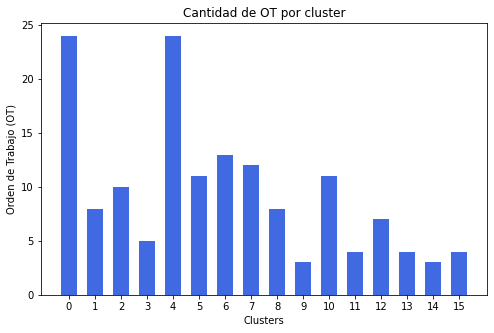

In [15]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 

# III. REQUERIMIENTOS

In [16]:
# SELECCIONANDO UN ESTADO OT ('PENDIENTE')
df = df_total[df_total[columna] == elemento] 
sentences = [sent for sent in df['Requerimiento']]
len(sentences)

151

In [17]:
# Extracto req 
sentences[:2]

['area de atencion breakaway esta suelto y filtra combustible solicitado por jonathan ibanez fono',
 'area de atencion surtidor doble funciona no despacha solicitado por walter pafian fono']

Número óptimo de clusters: 14


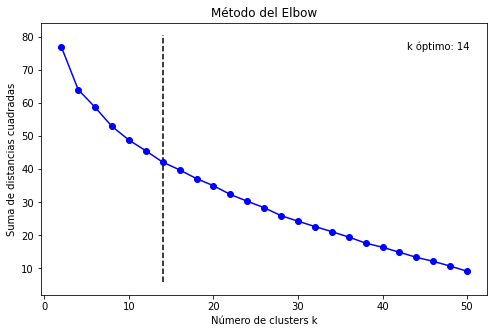

Wall time: 5.66 s


In [18]:
%%time
# Identificando el número óptimo de clústers por medio del método del Elbow
elbow_method(sentences, save = False)

Número óptimo de clusters: 10


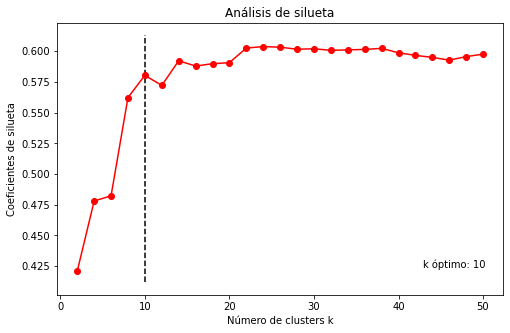

Wall time: 5.82 s


In [19]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta General
silhouette(sentences, save = False)

Wall time: 1.42 s


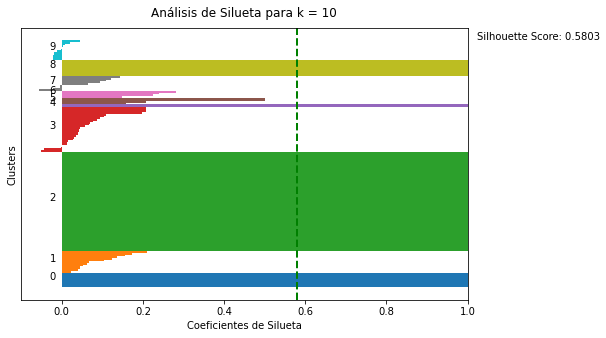

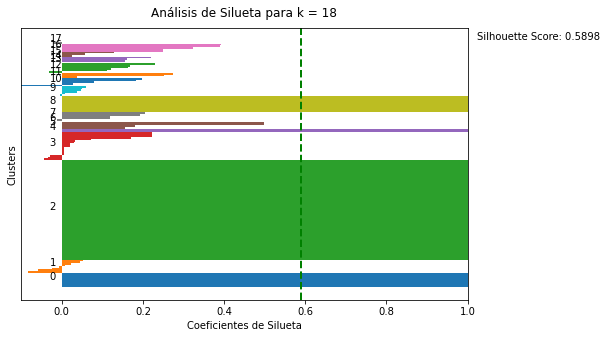

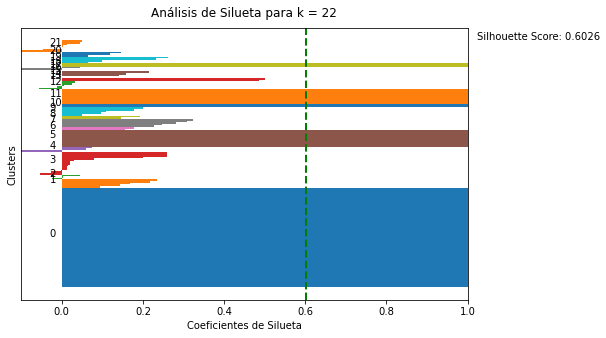

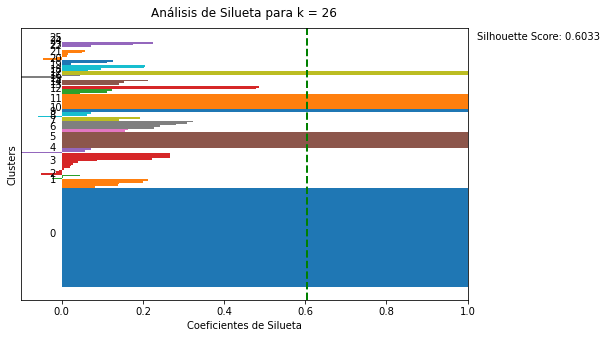

In [20]:
%%time
# Identificando el número óptimo de clústers por medio del Análisis de Silueta Particular (por tópico)
silhouette_analysis(sentences, n_clusters=[10,18,22,26], name= elemento+'Req', save=False)

In [21]:
# Ejecutando el algoritmo Kmeans para el número óptimo de clústers 
print('\033[1mCLUSTERS \n\033[0m')
start_time = time()

nclusters= 10
clusters,representativos = cluster_sentences(sentences, nclusters)

for cluster in range(nclusters):
    print (f"\033[1mCluster {cluster} : {sentences[clusters[cluster][representativos[cluster]]]}\033[0m")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tsentence ",i,": ",sentences[sentence])

elapsed_time = time() - start_time
print("\033[1mElapsed time: %.10f seconds.\033[0m" % elapsed_time)

CLUSTERS 

Cluster 0 : programa mantencion preventiva
	sentence  0 :  programa mantencion preventiva
	sentence  1 :  programa mantencion preventiva
	sentence  2 :  programa mantencion preventiva
	sentence  3 :  programa mantencion preventiva
	sentence  4 :  programa mantencion preventiva
	sentence  5 :  programa mantencion preventiva
	sentence  6 :  programa mantencion preventiva
	sentence  7 :  programa mantencion preventiva
	sentence  8 :  programa mantencion preventiva
Cluster 1 : fuga de combustible por el codo de torcion de la pistola
	sentence  0 :  gatillo de la pistola no danado no despacha combustible
	sentence  1 :  filtra combustible desde la pistola cuando se realiza la carga de combustible
	sentence  2 :  no despacha combustible regula emerg
	sentence  3 :  se demora despachar combustible
	sentence  4 :  fuga de combustible desde el breakaway ademas la otra pistola no funciona al accionar la palanca
	sentence  5 :  codo de torcion danado presenta fuga de combustible se sol

In [22]:
# Clusters representativos (con n = 10)
for cluster in range(nclusters):
    print ("\033[1mCluster ",cluster,":\033[0m",sentences[clusters[cluster][representativos[cluster]]])

Cluster  0 : programa mantencion preventiva
Cluster  1 : fuga de combustible por el codo de torcion de la pistola
Cluster  2 : programacion mantencion preventiva
Cluster  3 : surtidor despacha lento se solicita mantencion
Cluster  4 : coordinar barrido de linea tk de pd y revision de valvula de presion y vacio coordinar camion alza hombre segun corresponda
Cluster  5 : tapa de descarga quebrada
Cluster  6 : pistola no corta urgente visita
Cluster  7 : area de atencion ambas pistolas despachan demasiado lento lo que provoca gran atochamiento dentro del terminal ademas de derrame por que las pistolan no cortan se solicita acudir lo antes posible solicitado por jonathan ibanez fono
Cluster  8 : area de atencion mantencion preventiva solicitado por fono
Cluster  9 : surtidor sin despacho llamado emergencia 29 8


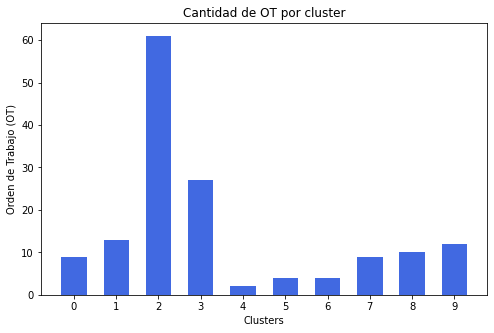

In [23]:
# Plot - Cantidad de sentences por cluster
len_clusters(dic=clusters,n = nclusters, save = False) 